# Imported all the necessary data, and loaded in the data set

In [720]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import *
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pylab 
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

path = '../../../data/kc_housing_data.csv'
all_data = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/bsc-phase-two-project/main/data/kc_house_data.csv')

In [721]:
all_data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,...,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,...,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,...,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,0.0,...,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


### Created a map of the area

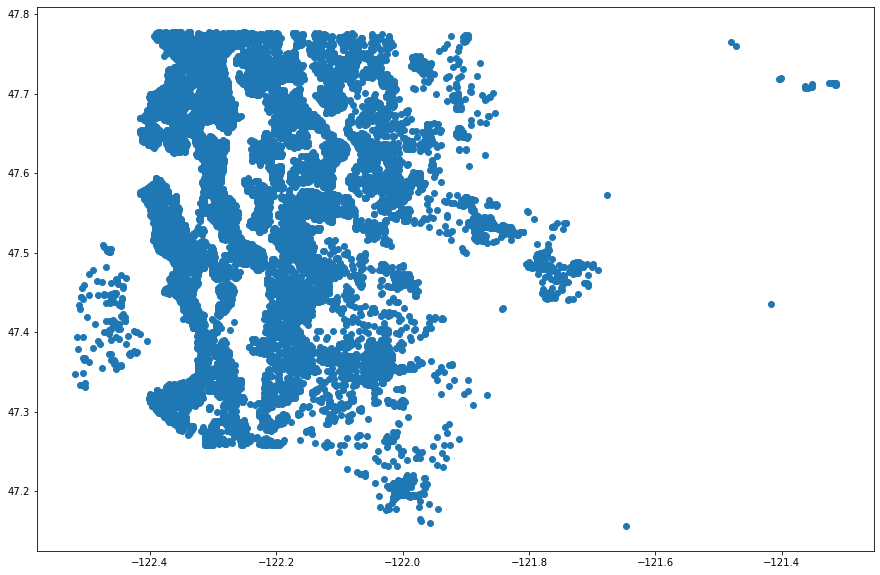

In [722]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x='long', y='lat', data=all_data)

In [723]:
all_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

# Creating new variables

### Added Age and Cleaned Columns

In [724]:
df = all_data.drop(['view', 'zipcode', 'lat', 'long', 'sqft_above', 'sqft_living15', 'sqft_lot15'], axis=1)

In [725]:
yrs = [int(x[-4:]) for x in df['date']]
df['date'] = yrs

In [726]:
for x in range(len(df)):
    if df['yr_renovated'][x] == True:
        if df['yr_renovated'][x] > 0:
            df['yr_built'][x] = df['yr_renovated'][x]

In [727]:
df['renovated'] = [int(x) for x in (df['yr_renovated'] > 0)]

In [728]:
df['yr_renovated/built'] = df['yr_built']

In [729]:
df['age'] = df['date'] - df['yr_renovated/built']

In [730]:
df.drop(['yr_renovated','yr_built', 'date'], axis=1, inplace=True)

### One-Hot Encoded Basement

In [731]:
df['sqft_basement'] = df['sqft_basement'].fillna(0)
df['sqft_basement'] = df['sqft_basement'].str.replace('?', '0')
df['sqft_basement'] = df['sqft_basement'].astype(float)
df['has_basement'] = [int(x) for x in df['sqft_basement'] > 0]
df = df.drop('sqft_basement', axis=1)

### Created new groups for region, and made 2 DataFrames

In [732]:
df['region'] = [int(x) for x in all_data['long'] > -121.95]

In [733]:
df_country = df.loc[df['region']==1]
df_seattle = df.loc[df['region']==0]

# Test models to see what is a good variable

In [734]:
X = sm.add_constant(df[['sqft_living', 'floors', 'grade', 'age']])
y = df['price']
model_1 = sm.OLS(Y, X)
results = model_1.fit()

In [735]:
X = df[['sqft_living', 'floors', 'grade', 'age']]

In [736]:
residuals = results.resid

In [737]:
preds = results.predict()

# Making a Function to check assumptions

In [738]:
def check_model(model, X, y):
    results = model.fit()
    residuals = results.resid
    preds = results.predict()
        
    display(rainbow(results), vif(X), heteroskd(preds, y), norm_resids(residuals))
           

### Function for Varience Inflection Factor

In [739]:
def vif(X_data):
    rows = X_data.values
    vif_df = pd.DataFrame()
    vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(4)]
    vif_df["feature"] = ['sqft_living', 'floors', 'grade', 'age']
    return vif_df

In [740]:
vif(X)

,VIF,feature
0,11.491152,sqft_living
1,12.178606,floors
2,31.400047,grade
3,3.102830,age


### Function of Normality of Residuals

In [741]:
def norm_resids(residuals):
    figureqq = sm.graphics.qqplot(residuals, dist=stats.norm, fit=True, line='45');

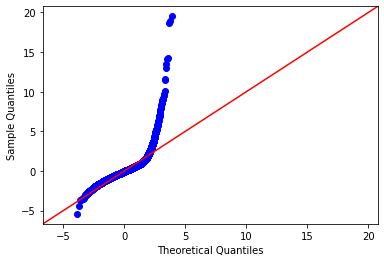

In [742]:
norm_resids(residuals)

### Function of Heteroskedascicity

In [743]:
def heteroskd (preds, Y):
    resids = preds - Y
    figure = sns.regplot(preds, resids, color='red', 
                       line_kws={'color':'blue'}, 
                       scatter_kws={'alpha':.5});
    return figure

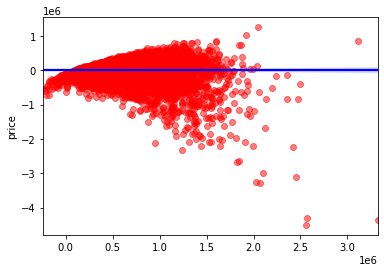

In [744]:
heteroskd(preds, Y);

### Function for Linear Rainbow Test

In [745]:
def rainbow(results):
    fstat, pvalue = sm.stats.diagnostic.linear_rainbow(results)
    return f'P-value of linearity: {pvalue}'

In [746]:
rainbow(results)

'P-value of linearity: 2.467415663044872e-09'

### Function for idenfying outliers and number of outliers

In [747]:
def outliers(df, column):
    Q1 = df[column].quantile(.25)
    Q3 = df[column].quantile(.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5 * IQR
    upper_lim = Q3 + 1.5 * IQR
    
    return lower_lim, upper_lim

In [749]:
def outlier_count(column):
    high_o = (df[column] > outliers(column)[1]).sum()
    low_o = (df[column] < outliers(column)[0]).sum()
    return high_o, low_o

# Models for Seattle and Country Areas

In [761]:
X_seattle = sm.add_constant(df_seattle[['sqft_living','grade','age', 'bathrooms']])
y_seattle = df_seattle['price']
X_country = sm.add_constant(df_country[['sqft_living','grade','age', 'bathrooms']])
y_country = df_country['price']
model_seattle = sm.OLS(y_seattle, X_seattle)
model_country = sm.OLS(y_country, X_country)
results_seattle = model_seattle.fit()
results_country = model_country.fit()

'P-value of linearity: 0.8629425388523382'

,VIF,feature
0,94.128933,sqft_living
1,3.972789,floors
2,3.164854,grade
3,1.927620,age


None

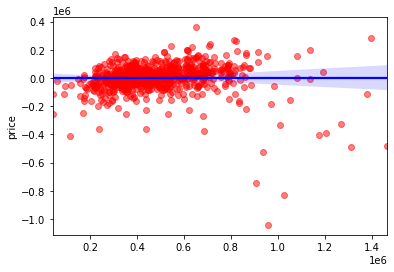

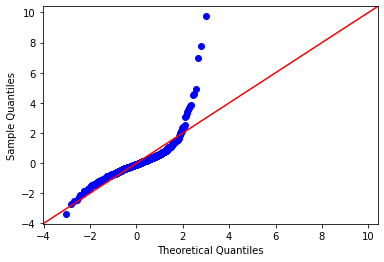

In [764]:
check_model(model_country, X_country, y_country)

# Scrap

In [693]:
X = df[['sqft_living','grade','age', 'bathrooms']]
y = df['price']
model_2 = sm.MixedLM.from_formula("price ~ sqft_living + grade + age + bathrooms",
           groups="region", data=df)
results_2 = model_2.fit()
results_2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:                  MixedLM     Dependent Variable:     price           
No. Observations:       21597       Method:                 REML            
No. Groups:             1           Scale:                  53062705117.5748
Min. group size:        21597       Log-Likelihood:         -297276.1084    
Max. group size:        21597       Converged:              Yes             
Mean group size:        21597.0                                             
----------------------------------------------------------------------------
                 Coef.       Std.Err.    z    P>|z|    [0.025       0.975]  
----------------------------------------------------------------------------
Intercept      -1139591.539 230768.604 -4.938 0.000 -1591889.693 -687293.386
sqft_living         154.614      3.176 48.681 0.000      148.389     160.839
grade            142249.191   2199.648 64.669 0.000   137937.959  146560.422
age                4010.042     64.876 61.811 0.000     3882.887    4137.196
bathrooms         44985.360   3458.182 13.008 0.000    38207.449   51763.272
region Var  53062705117.575                                                 
============================================================================

"""